<a href="https://www.kaggle.com/code/bibekrai/family-guy-character-prediction?scriptVersionId=295490233" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install --upgrade caer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.4/192.4 kB 11.4 MB/s eta 0:00:00


In [3]:
import os
import caer
import numpy as np
import cv2 as cv
import gc

In [4]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'/kaggle/input/family-guy-image-dataset/Dataset/train'

In [5]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('Stewie Griffin', 200),
 ('Brain Griffin', 174),
 ('Peter Griffin', 166),
 ('Lois Griffin', 135)]

In [6]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['Stewie Griffin', 'Brain Griffin', 'Peter Griffin', 'Lois Griffin']

In [7]:
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] 194 files found in 0.0011708736419677734s
[INFO] 173 files found in 0.0008807182312011719s
[INFO] 163 files found in 0.17814040184020996s
[INFO] 128 files found in 0.1867225170135498s
----------------------------------------------
[INFO] 658 files preprocessed! Took 0m 8s


In [8]:
len(train)

658

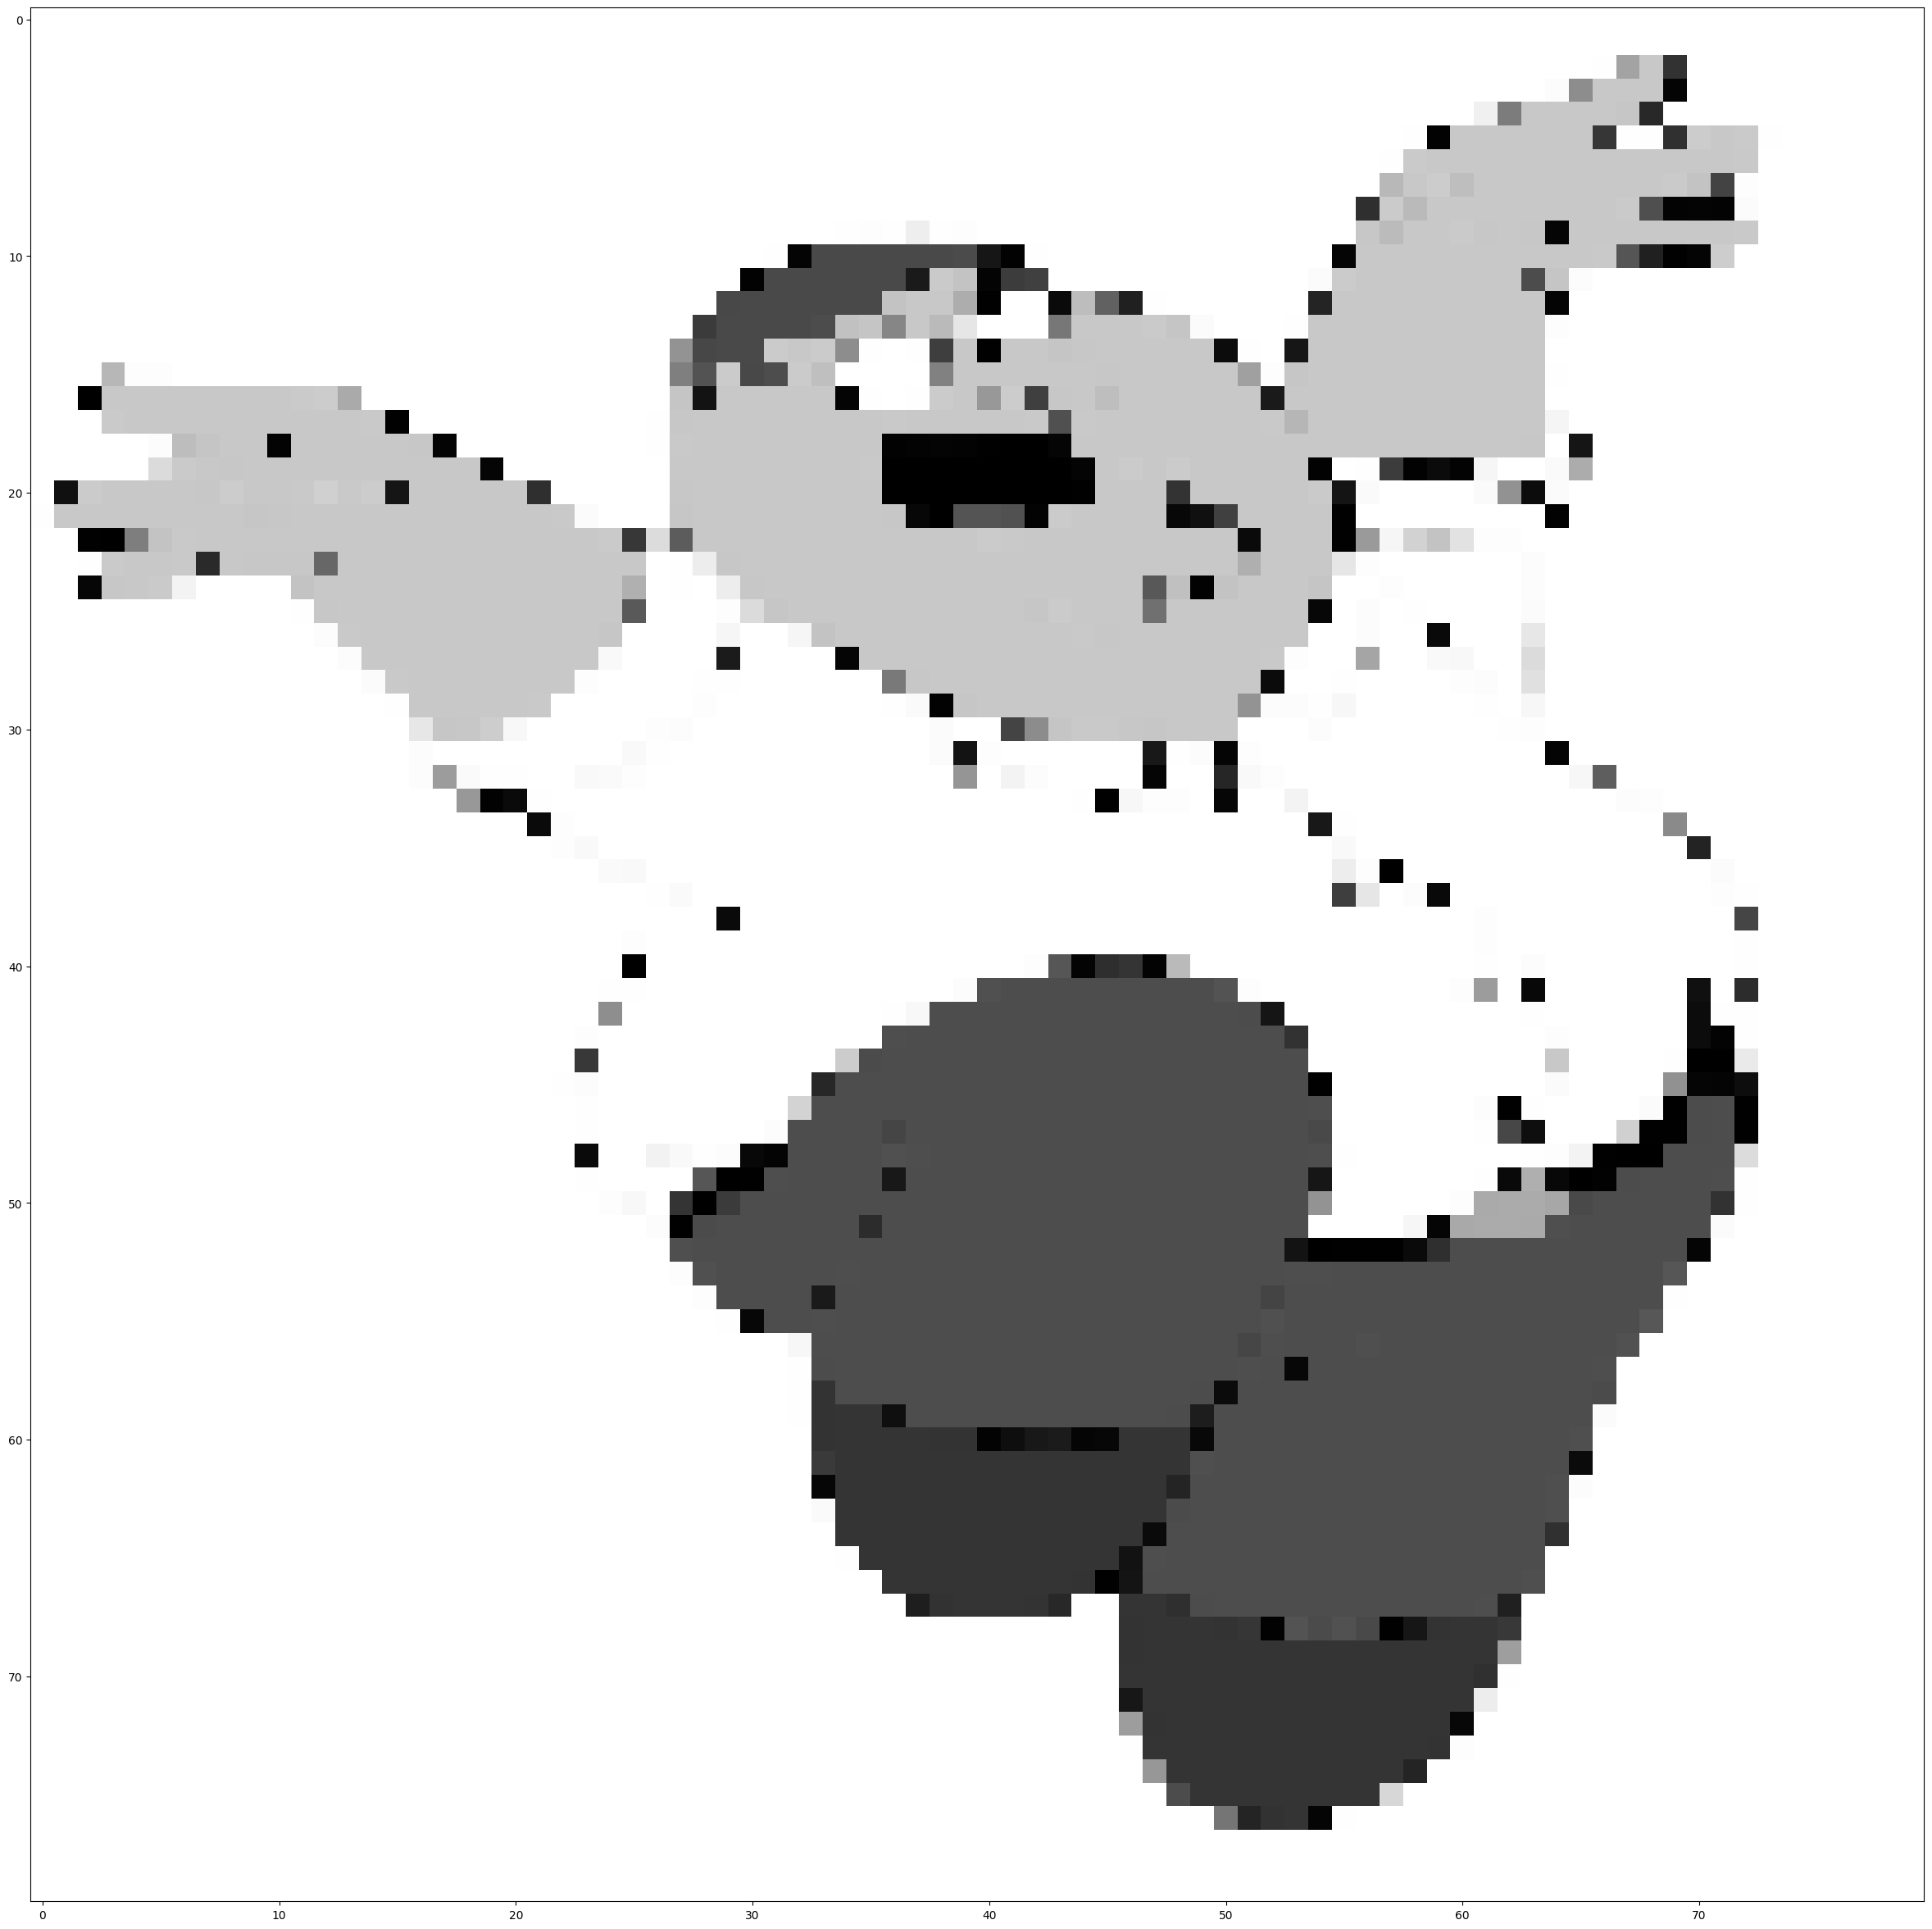

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [10]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [11]:
from tensorflow.keras.utils import to_categorical

featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

2026-02-02 15:02:21.252266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770044541.504563      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770044541.577326      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770044542.217285      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770044542.217320      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770044542.217323      17 computation_placer.cc:177] computation placer alr

In [12]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [13]:
del train
del featureSet
del labels 
gc.collect()

0

In [14]:
BATCH_SIZE = 32
EPOCHS = 10

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create the training generator
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [16]:
import tensorflow as tf

# Create a dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

2026-02-02 15:02:40.057684: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

output_dim=10

w, h = IMG_SIZE[:2]

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h,channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))

# Output Layer
model.add(Dense(output_dim, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 80, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 78, 78, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 39, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,591,274 (67.11 MB)

 Trainable params: 17,591,274 (67.11 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.optimizers import SGD

optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"Number of unique classes: {len(np.unique(y_train))}")

x_train shape: (525, 80, 80, 1)
y_train shape: (525, 4)
x_val shape: (133, 80, 80, 1)
y_val shape: (133, 4)
Number of unique classes: 2


In [21]:
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 80, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 78, 78, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 39, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,591,274 (67.11 MB)

 Trainable params: 17,591,274 (67.11 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [23]:
characters

['Stewie Griffin', 'Brain Griffin', 'Peter Griffin', 'Lois Griffin']

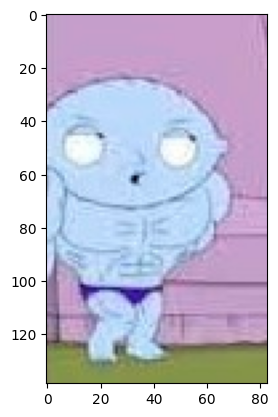

In [24]:
test_path = r'/kaggle/input/family-guy-image-dataset/Dataset/test/Stewie Griffin/hq2 (4).jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [25]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [26]:
predictions = model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


In [27]:
print(characters[np.argmax(predictions[0])])

Stewie Griffin
